# Movie 2 - AQP4 Distribution in migrating cell
## Load movie frames and perform segmentations

In [50]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns

movie2_path = "movies/movie2.avi"

In [52]:
# Find contours and get the largest contour to represent the entire structure
# Get bounding rectangle of leftmost and rightmost sides
def get_bounding_boxes(img):
    contours, hierarchy = cv2.findContours(img, 1, 2)
    c = max(contours, key=cv2.contourArea)
    
    leftBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmin()])
    rightBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmax()])

    return leftBoundingRect, rightBoundingRect, c

def check_sections(frame, check_size=10, min_mean_pixel=0.03):
    sections = []
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        #print("Current mean pixel:", mean_pixel)
        sections.append((mean_pixel, c, check_size))
    return sections

def get_left_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

def get_right_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(frame.shape[1], 0, -(check_size)):
        mean_pixel = cv2.mean(frame[:,c-check_size:c])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0


def get_segment_gaps(right_segments, edge=0, side='left', fill_size=2, space_from_edge=0):
    gaps = []
    for i in range(1,len(right_segments)):
        px, py, pw, ph = right_segments[i-1]
        nx, ny, nw, nh = right_segments[i]
        
        gx = edge+space_from_edge if side=='left' else edge-fill_size-space_from_edge
        gy = (py+ph)-1 if py+ph<=ny else (ny+nh)-1
        gw = fill_size
        gh = ny-(py+ph)+2 if py+ph<=ny else py-(ny+nh) +2

        print("Gap:", (gx, gy, gw, gh))
        gaps.append((gx, gy, gw, gh))
    return gaps

def remove_non_edge_segments(img, non_edge_thresh=105):
    remove_thresh = cv2.threshold(img, non_edge_thresh, 255, cv2.THRESH_BINARY)[1]
    diff_img = cv2.subtract(img, remove_thresh)
    return diff_img

def get_mean_intensity(section):
    count = np.nonzero(section)[0].size
    mean = np.sum(section) / count
    #print(count, mean)
    return count, mean

outliers = []

In [54]:
print("Press 'q' to end video")
cap = cv2.VideoCapture(movie2_path)

# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width, height)

# Initialize video writer to save segmented movie at 1 frame per second
writer = cv2.VideoWriter("movie2_segments.avi", cv2.VideoWriter_fourcc(*"XVID"), 1.0, frame_size)

frame_index = 0

data = []

while True:
    frame_index += 1
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to remove text
        canvas = np.zeros((frame.shape), np.uint8)
        canvas[35:90, :] = frame[35:90, :]
        isolated_cell = frame[35:90, :]
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 14, 255, cv2.THRESH_BINARY)
        _, imgThresh = cv2.threshold(gray_frame, 8, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, (7, 7), 0)

        left_end = get_left_side(imgThresh, check_size=5, min_mean_pixel=20)
        right_end = get_right_side(imgThresh, check_size=5, min_mean_pixel=9)
        
        edge_width = 30
        right_edge_width = 15

        left_min_threshold = 15
        right_min_threshold = 16 if frame_index != 12 or frame_index != 13 else 20

        if frame_index == 7:
            right_min_threshold = 22

        left_non_edge_threshold = 40
        right_non_edge_threshold = 20 if frame_index != 4 else 30

        edge_blur_value_x = 3
        edge_blur_value_y = 3

        left_side_thickness = 30
        right_side_thickness = 30
        left_side_offset_correction = 0
        right_side_offset_correction = 0

        left_section = remove_non_edge_segments(gray_frame[:, left_end:left_end+edge_width], left_non_edge_threshold) # remove_non_edge_segments(gray_frame[:, left_end:left_end+edge_width], 120)
        left_blur = cv2.blur(left_section, (edge_blur_value_x, edge_blur_value_y))
        _, left_thresh = cv2.threshold(left_blur, left_min_threshold, 255, cv2.THRESH_BINARY)

        right_section = remove_non_edge_segments(gray_frame[:, right_end-right_edge_width:right_end], right_non_edge_threshold) # remove_non_edge_segments(gray_frame[:, right_end-right_edge_width:right_end], 255)
        # 34 for most frames
        right_section[right_section >= 4] = 30
        # print("EDGE:", right_section[right_section > 10])
        right_blur = cv2.blur(right_section, (edge_blur_value_x, edge_blur_value_y))
        _, right_thresh = cv2.threshold(right_blur, right_min_threshold, 255, cv2.THRESH_BINARY)

        # imgThreshold[:, left_end:left_end+edge_width] = left_thresh
        imgThreshold[:, right_end-right_edge_width:right_end] = right_thresh

        # noise removal
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        bin_img = cv2.morphologyEx(imgThreshold, 
                                   cv2.MORPH_OPEN,
                                   kernel,
                                   iterations=2)

        sure_bg = cv2.dilate(bin_img, kernel, iterations=3)

        dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 0)

        ret, sure_fg = cv2.threshold(dist, 0.21 * dist.max(), 255, cv2.THRESH_BINARY)
        sure_fg = sure_fg.astype(np.uint8)

        unknown = cv2.subtract(sure_bg, sure_fg)

        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)

        # Add one to all labels so that background is not 0, but 1
        markers += 1
        # mark the region of unknown with zero
        markers[unknown == 255] = 0

        # create watershed markers
        markers = cv2.watershed(canvas, markers)

        labels = np.unique(markers)
        right_segments = []

        edges = {
            "left":{
                "frame_index":0,
                "count": 0,
                "mean": 0,
                "num_of_segments":0
            },
            "right":{
                "frame_index":0,
                "count": 0,
                "mean": 0,
                "num_of_segments":0
            },
        }
        for label in labels[2:]: 
            target = np.where(markers == label, 255, 0).astype(np.uint8)
            x, y, w, h = cv2.boundingRect(target)

            min_segment_to_edge_distance = 10

            color = (255, 255, 255)
            if x-left_end <= min_segment_to_edge_distance:
                if len(canvas[markers == label]) > 10:
                    count, mean = get_mean_intensity(canvas[markers == label])
                    edges["left"]["frame_index"] = frame_index
                    edges["left"]["count"] += count
                    edges["left"]["mean"] += mean
                    edges["left"]["num_of_segments"] += 1
    
                    canvas[markers == label] = [255, 0, 255]
                    cv2.putText(canvas, "L", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1, cv2.LINE_AA)
            elif right_end-(w+x) <= min_segment_to_edge_distance:
                count, mean = get_mean_intensity(canvas[markers == label])
                edges["right"]["frame_index"] = frame_index
                edges["right"]["count"] += count
                edges["right"]["mean"] += mean
                edges["right"]["num_of_segments"] += 1

                canvas[markers == label] = [255, 255, 0]
                cv2.putText(canvas, "R", (x+w, y+h), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1, cv2.LINE_AA)
                #right_rect = cv2.rectangle(canvas,(x,y),(x+w,y+h),(0,0,255),1)
                right_segments.append((x, y, w, h))
            else:
                rand_color = [0, 0, 255]
                canvas[markers == label] = rand_color

        if edges["left"]["num_of_segments"] > 0:
            data.append([edges["left"]["frame_index"], "L", edges["left"]["count"], edges["left"]["mean"]/edges["left"]["num_of_segments"]])
        if edges["right"]["num_of_segments"] > 0:
            data.append([edges["right"]["frame_index"], "R", edges["right"]["count"], edges["right"]["mean"]/edges["right"]["num_of_segments"]])

        # rect = cv2.rectangle(canvas, (c_x,c_y), (c_x+c_w,c_y+c_h), color, 1)
        cv2.rectangle(canvas, (left_end, 35), (right_end, 90), (255, 255, 255), 1)
        writer.write(canvas)

        img_stacked = np.concatenate((imgThreshold, gray_frame), axis=0)

        title = "Movie 2: AQP4 imaging segments"
        #title = f'FRAME: {frame_index}'

        cv2.imshow(title, canvas)

    # 1 frame per second
    if cv2.waitKey(1000) & 0xFF == ord('q'):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

Press 'q' to end video


In [56]:
data_df = pd.DataFrame(data, columns =  ["Frame", "Edge", "Intensity Count","Mean Intensity"])
dummies = pd.get_dummies(data_df)
data_with_dummies_df = pd.concat([data_df, dummies[["Edge_L"]]], axis='columns')
cleaned_data = data_with_dummies_df.drop(['Edge'], axis='columns')*1
cleaned_data.head()

,Frame,Intensity Count,Mean Intensity,Edge_L
0,1,586,91.747440,1
1,1,715,27.892308,0
2,2,726,94.983471,1
3,2,634,23.547319,0
4,3,432,96.817130,1


<Axes: >

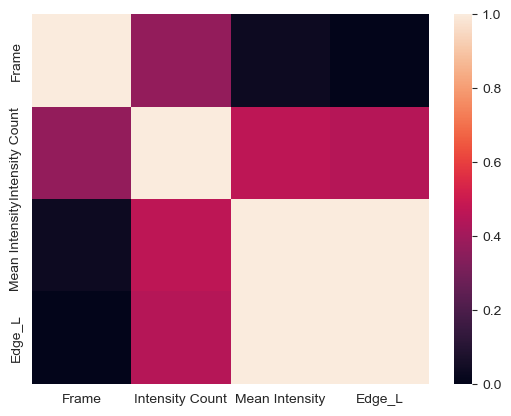

In [58]:
# Correlation
sns.heatmap(cleaned_data.corr())

Text(0.5, 0.98, 'Plot Fluorescence at Left (1) and Right (0) edges')

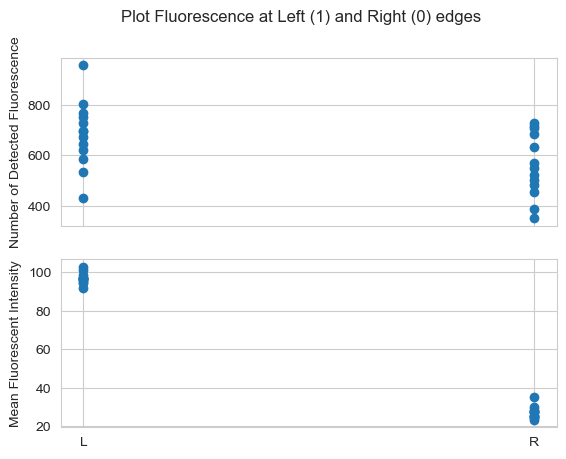

In [60]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
x = data_df["Edge"]
y1 = cleaned_data["Intensity Count"]
y2 = cleaned_data["Mean Intensity"]

ax1.scatter(x, y1)
ax2.scatter(x, y2)
 
ax1.set_ylabel('Number of Detected Fluorescence')
ax2.set_ylabel('Mean Fluorescent Intensity')
 
fig.suptitle('Plot Fluorescence at Left (1) and Right (0) edges')

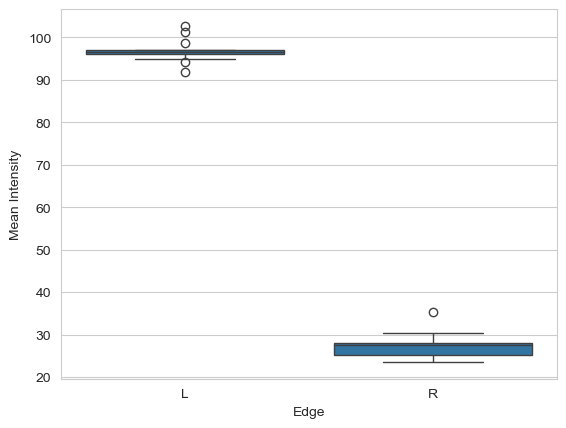

In [62]:
sns.set_style("whitegrid")
bplot = sns.boxplot(x = 'Edge', y = 'Mean Intensity', data = data_df)
fig = bplot.get_figure()
fig.savefig('movie2_mean_intensity_boxplot.png')

<Axes: xlabel='Edge', ylabel='Intensity Count'>

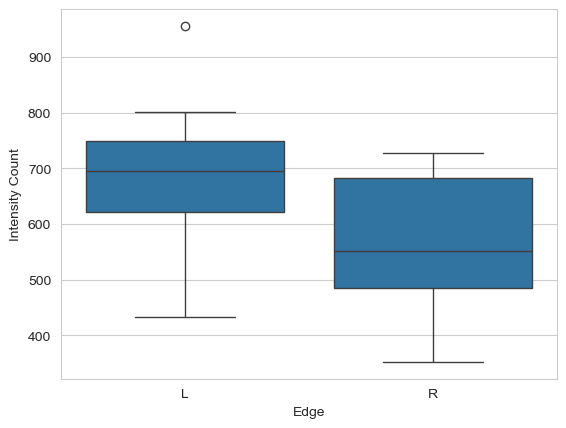

In [64]:
sns.boxplot(x = 'Edge', y = 'Intensity Count', data = data_df)

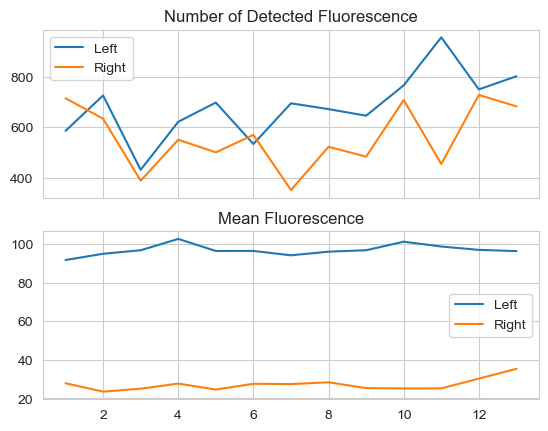

In [66]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

left_edge_data = data_df[data_df["Edge"] == "L"]
right_edge_data = data_df[data_df["Edge"] == "R"]

X = left_edge_data["Frame"]
Y1 = left_edge_data["Intensity Count"]
Y2 = right_edge_data["Intensity Count"]

Y3 = left_edge_data["Mean Intensity"]
Y4 = right_edge_data["Mean Intensity"]

ax1.plot(X, Y1)
ax1.plot(X, Y2)
ax1.set_title("Number of Detected Fluorescence")

ax2.plot(X, Y3)
ax2.plot(X, Y4)
ax2.set_title("Mean Fluorescence")

ax1.legend(["Left","Right"],loc='best') 
ax2.legend(["Left","Right"],loc='best')

plt.savefig("movie2_fluorescence_line_plot.png")
plt.show()

In [68]:
## Left edge
Q3 = np.quantile(left_edge_data["Mean Intensity"], 0.75)
Q1 = np.quantile(left_edge_data["Mean Intensity"], 0.25)
IQR = Q3 - Q1
lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR
left_mean_outliers = left_edge_data[(left_edge_data["Mean Intensity"] < lower_range) | (left_edge_data["Mean Intensity"] > upper_range)]
outliers = list(set(outliers + list(left_mean_outliers["Frame"])))
outliers.sort()
print("Left edge outliers:", outliers)

Left edge outliers: [1, 4, 7, 10, 11]


In [70]:
## Right edge
Q3 = np.quantile(right_edge_data["Mean Intensity"], 0.75)
Q1 = np.quantile(right_edge_data["Mean Intensity"], 0.25)
IQR = Q3 - Q1
lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR
right_mean_outliers = right_edge_data[(right_edge_data["Mean Intensity"] < lower_range) | (right_edge_data["Mean Intensity"] > upper_range)]
outliers = list(set(outliers + list(right_mean_outliers["Frame"])))
outliers.sort()
print("Right edge outliers:", outliers)

Right edge outliers: [1, 4, 7, 10, 11, 13]


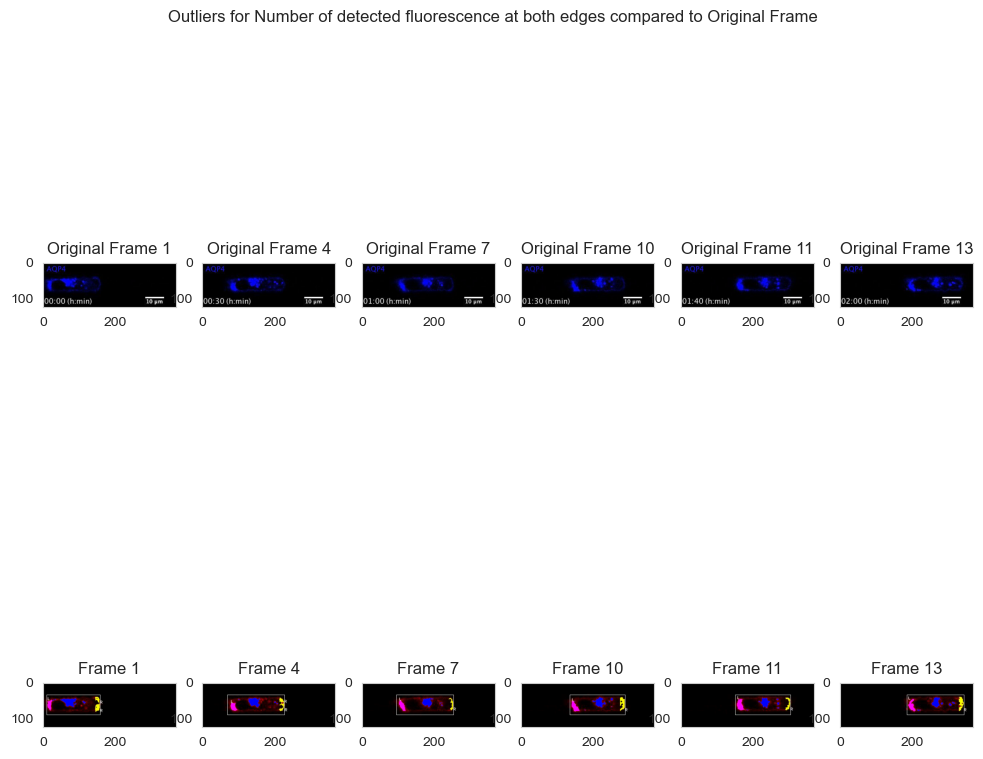

In [72]:
if len(outliers) > 0:
    fig, (axes1, axes2) = plt.subplots(2, len(outliers), sharex=False, sharey=False, figsize=(12, 10))
    
    video_name = "movie2_segments.avi"
    cap = cv2.VideoCapture(video_name)
    
    if len(outliers) > 1:
        for i in range(0, len(outliers)):
            frame = cv2.imread(f"movies/movie2/{outliers[i]}.jpg")
            axes1[i].grid(False)
            axes1[i].imshow(frame)
            axes1[i].set_title(f'Original Frame {outliers[i]}')
    elif len(outliers) == 1:
        frame = cv2.imread(f"movies/movie2/{outliers[0]}.jpg")
        axes1.grid(False)
        axes1.imshow(frame)
        axes1.set_title(f'Original Frame {outliers[0]}')

    if len(outliers) > 1:
        for i in range(0, len(outliers)):
            cap.set(1, outliers[i]-1)
            ret, frame = cap.read()
            axes2[i].grid(False)
            axes2[i].imshow(frame)
            axes2[i].set_title(f'Frame {outliers[i]}')

    elif len(outliers) == 1:
        cap.set(1,outliers[0]-1)
        ret, frame = cap.read()
        axes2.grid(False)
        axes2.imshow(frame)
        axes2.set_title(f'Frame {outliers[0]}')
            
    cap.release()
    plt.suptitle("Outliers for Number of detected fluorescence at both edges compared to Original Frame")
    plt.savefig("movie2_outliers.png")
    plt.show()

In [74]:
data_df[data_df["Frame"].isin(outliers)]

,Frame,Edge,Intensity Count,Mean Intensity
0,1,L,586,91.747440
1,1,R,715,27.892308
6,4,L,622,102.686495
7,4,R,551,27.722081
12,7,L,695,94.185612
13,7,R,352,27.460227
18,10,L,766,101.238903
19,10,R,708,25.197740
20,11,L,956,98.750000
21,11,R,455,25.228571


In [76]:
import scipy.stats as stats
stats.f_oneway(left_edge_data["Intensity Count"], right_edge_data["Intensity Count"])

F_onewayResult(statistic=5.980525555930918, pvalue=0.022176870630420974)

- No significance difference between edge intensity counts

In [79]:
stats.f_oneway(left_edge_data["Mean Intensity"], right_edge_data["Mean Intensity"])

F_onewayResult(statistic=3617.6182645508643, pvalue=1.0855224591459438e-27)

- Mean intensity on the left edge significantly different from that on the right edge
    - F = 3617.618
    - P-value = 1.086e-27